In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set plot style
plt.style.use('seaborn-v0_8')

Real data often comes with mixed formats. We create a small dataframe with inconsistent dates to demonstrate how to standardize them into a proper DatetimeIndex.

In [9]:
# Setup: Create a dataframe with messy, mixed-format timestamps
data = {
    "timestamp": [
        "2023-01-01 08:00:00",    # ISO format
        "01/01/23 9:00 AM",       # US format with AM/PM
        "2023-01-01T10:00:00",    # ISO format, no seconds
        "1/1/2023 11:00:00",      # US format, different style
        "2023-01-01 08:00:00"     # Duplicate to test validation
    ],
    "value": [10, 12, 15, 14, 10]
}
df = pd.DataFrame(data)

# 1. Convert mixed formats to DatetimeIndex
# 'mixed' format argument helps pandas infer different styles automatically
df['timestamp'] = pd.to_datetime(df['timestamp'], format='mixed')

# 2. Set index and sort
df = df.set_index('timestamp').sort_index()

# 3. Validate temporal structure
print(f"Date range: {df.index.min()} to {df.index.max()}")

# Check for duplicates
if df.index.duplicated().any():
    print(f"Warning: {df.index.duplicated().sum()} duplicate timestamps found")
    # Fix: Keep the first occurrence
    df = df[~df.index.duplicated(keep='first')]
    print("Duplicates removed.")

# Check frequency (will be None/Irregular initially due to gaps or mixed data)
print(f"Frequency: {pd.infer_freq(df.index) or 'Irregular'}")

Date range: 2023-01-01 08:00:00 to 2023-01-01 11:00:00
Duplicates removed.
Frequency: h


Different data types require different filling methods. We create three synthetic series—Temperature (continuous), Machine Status (state), and Sales (count)—to show why the method must match the data type.

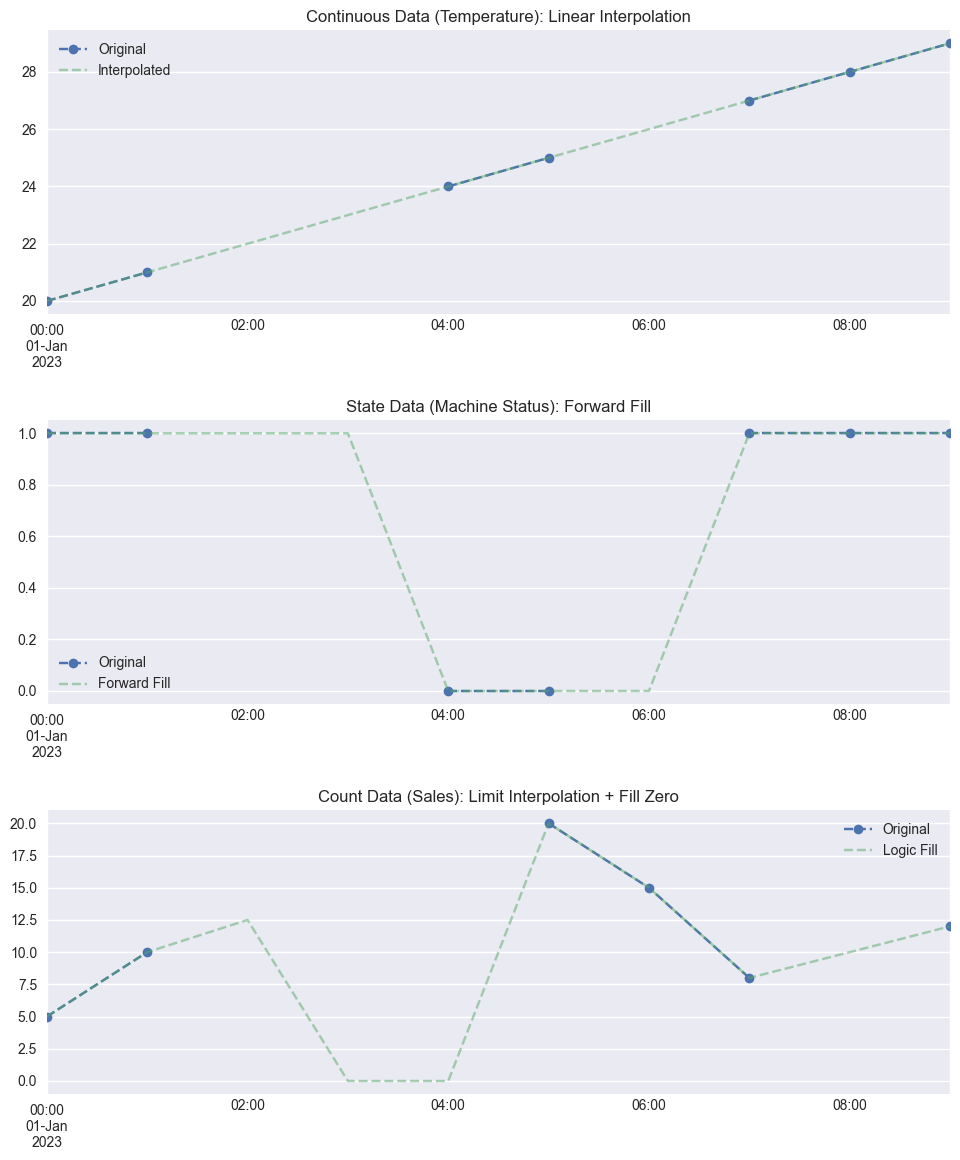

In [10]:
# Setup: Create synthetic series with gaps
times = pd.date_range('2023-01-01', periods=10, freq='h')
temperature_series = pd.Series([20, 21, np.nan, np.nan, 24, 25, np.nan, 27, 28, 29], index=times)
machine_status = pd.Series([1, 1, np.nan, np.nan, 0, 0, np.nan, 1, 1, 1], index=times)
sales_data = pd.Series([5, 10, np.nan, np.nan, np.nan, 20, 15, 8, np.nan, 12], index=times)

# Strategy 1: Interpolation for continuous data (Physical measurements)
# Linear interpolation guesses values on a straight line between known points
temp_filled = temperature_series.interpolate(method='linear')

# Strategy 2: Forward-fill for state data (Discrete states)
# The machine stays 'On' (1) until we see it turn 'Off' (0)
status_filled = machine_status.ffill()

# Strategy 3: Business-aware filling
# Interpolate small gaps (lunch break), fill large gaps with 0 (store closed)
sales_filled = sales_data.interpolate(limit=1)  # Only bridge 1-hour gaps
sales_filled = sales_filled.fillna(0)           # Remaining gaps are closed hours

# Visualization
fig, axes = plt.subplots(3, 1, figsize=(10, 12))

temperature_series.plot(ax=axes[0], marker='o', label='Original')
temp_filled.plot(ax=axes[0], alpha=0.5, linestyle='--', label='Interpolated')
axes[0].set_title('Continuous Data (Temperature): Linear Interpolation')
axes[0].legend()

machine_status.plot(ax=axes[1], marker='o', label='Original')
status_filled.plot(ax=axes[1], alpha=0.5, linestyle='--', label='Forward Fill')
axes[1].set_title('State Data (Machine Status): Forward Fill')
axes[1].legend()

sales_data.plot(ax=axes[2], marker='o', label='Original')
sales_filled.plot(ax=axes[2], alpha=0.5, linestyle='--', label='Logic Fill')
axes[2].set_title('Count Data (Sales): Limit Interpolation + Fill Zero')
axes[2].legend()

plt.tight_layout()
plt.show()

We run a quick diagnostic check to flag if a series has too much missing data or gaps that are too large to safely interpolate.

In [11]:
def check_data_quality(series, name="Series"):
    missing_pct = series.isnull().sum() / len(series) * 100
    
    # Calculate gap sizes
    # Group by consecutive valid blocks to find size of invalid blocks
    gap_sizes = series.isnull().astype(int).groupby((~series.isnull()).cumsum()).sum()
    max_gap = gap_sizes.max()

    print(f"--- {name} ---")
    print(f"Missing data: {missing_pct:.1f}%")
    print(f"Largest gap: {max_gap} periods")

    if missing_pct > 20:
        print("WARNING: High missing data percentage")
    if max_gap > 3: # Strict threshold for this example
        print("WARNING: Large gaps detected")
    print("\n")

check_data_quality(temperature_series, "Temperature Data")
check_data_quality(sales_data, "Sales Data")

--- Temperature Data ---
Missing data: 30.0%
Largest gap: 2 periods


--- Sales Data ---
Missing data: 40.0%
Largest gap: 3 periods




Downsampling requires choosing an aggregation function that preserves the meaning of the variable (Mean vs. Sum vs. Last).

In [12]:
# Setup: High frequency minute data
rng = pd.date_range('2023-01-01', periods=120, freq='min')
minute_temp = pd.Series(np.random.normal(20, 1, 120), index=rng) # random temp
minute_sales = pd.Series(np.random.randint(0, 5, 120), index=rng) # random sales count
hourly_inventory = pd.Series(np.linspace(100, 90, 120), index=rng) # declining inventory

# 1. Intensive variables (Temperature): Use mean
# Averaging preserves the "level" of the temperature
hourly_temp = minute_temp.resample('h').mean()

# 2. Extensive variables (Sales): Use sum
# Summing preserves the total volume of sales
hourly_sales = minute_sales.resample('h').sum()

# 3. Balance variables (Inventory): Use last
# The last value reflects the state at the end of the hour
hourly_inv = hourly_inventory.resample('h').last()

print(f"Temperature (Mean): \n{hourly_temp}\n")
print(f"Sales (Sum): \n{hourly_sales}\n")
print(f"Inventory (Last): \n{hourly_inv}")

Temperature (Mean): 
2023-01-01 00:00:00    20.089379
2023-01-01 01:00:00    20.091481
Freq: h, dtype: float64

Sales (Sum): 
2023-01-01 00:00:00    132
2023-01-01 01:00:00    116
Freq: h, dtype: int64

Inventory (Last): 
2023-01-01 00:00:00    95.042017
2023-01-01 01:00:00    90.000000
Freq: h, dtype: float64


This cell demonstrates a critical error: using bfill (backfill) during resampling. This leaks future information into the past. We compare it with the correct ffill approach.

In [13]:
# Setup: Daily data with some missing days
dates = pd.date_range('2023-01-01', '2023-01-05', freq='D')
daily_data = pd.Series([100, np.nan, 105, np.nan, 110], index=dates)

print("Original Data:")
print(daily_data)

# WRONG: bfill uses future values to fill past gaps
# On Jan 2nd, you wouldn't know the value of Jan 3rd (105) yet
bad_fill = daily_data.resample('D').bfill()

# RIGHT: ffill uses only past values
# On Jan 2nd, you only know the value of Jan 1st (100)
good_fill = daily_data.resample('D').ffill()

print("\nBad Fill (Lookahead Bias):")
print(bad_fill)

print("\nGood Fill (Causal):")
print(good_fill)

Original Data:
2023-01-01    100.0
2023-01-02      NaN
2023-01-03    105.0
2023-01-04      NaN
2023-01-05    110.0
Freq: D, dtype: float64

Bad Fill (Lookahead Bias):
2023-01-01    100.0
2023-01-02      NaN
2023-01-03    105.0
2023-01-04      NaN
2023-01-05    110.0
Freq: D, dtype: float64

Good Fill (Causal):
2023-01-01    100.0
2023-01-02      NaN
2023-01-03    105.0
2023-01-04      NaN
2023-01-05    110.0
Freq: D, dtype: float64
